In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import os

from sklearn import preprocessing
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 500)

In [2]:
%%time
train = pd.read_csv('train_joined.csv', parse_dates=['timestamp'])

Wall time: 31.8 s


## Take out cloud_coverage, precip_depth_1_hr, wind_direction, and  sea_level_pressure for now, and drop some missing values

In [3]:
train = train.drop(['year_built', 'floor_count', 'Unnamed: 0', 
                    'precip_depth_1_hr', 'cloud_coverage', 'sea_level_pressure', 'wind_direction'], axis=1)
train = train.dropna()
train.isnull().sum()/train.shape[0]

building_id        0.0
meter              0.0
timestamp          0.0
meter_reading      0.0
site_id            0.0
primary_use        0.0
square_feet        0.0
air_temperature    0.0
dew_temperature    0.0
wind_speed         0.0
dtype: float64

## Prepocess
1. Label primary_use 
2. move y to the first column
3. Remove first 5 months in site 0
4. Add month, week day, day, hour

In [4]:
le = preprocessing.LabelEncoder()
train['primary_use'] = le.fit_transform(train['primary_use'])

move = ['meter_reading', 'timestamp'] + [x for x in train.columns if x not in ['meter_reading', 'timestamp']]
train = train[move]

In [7]:
mask =(train['site_id']==0) & (train['timestamp'] < '2016-06-01')
train = train[~mask]

In [8]:
## this may take mins
train['date_month'] = train['timestamp'].map(lambda x: x.month)
train['date_day'] = train['timestamp'].map(lambda x: x.day)
train['iso_week'] = train['timestamp'].map(lambda x: x.isocalendar()[1])
train['iso_weekend'] = train['timestamp'].map(lambda x: x.isocalendar()[2])
train['hour'] = train['timestamp'].map(lambda x: x.hour)

In [5]:
train.head()

,meter_reading,timestamp,building_id,meter,site_id,primary_use,square_feet,air_temperature,dew_temperature,wind_speed
0,0.0,2016-01-01,0,0,0,0,7432,25.0,20.0,0.0
1,0.0,2016-01-01,1,0,0,0,2720,25.0,20.0,0.0
2,0.0,2016-01-01,2,0,0,0,5376,25.0,20.0,0.0
3,0.0,2016-01-01,3,0,0,0,23685,25.0,20.0,0.0
4,0.0,2016-01-01,4,0,0,0,116607,25.0,20.0,0.0


## Model code

In [ ]:
# %%time
# X = train.iloc[:,2:]
# y = train.iloc[:,0]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# bst = lgb.LGBMRegressor(n_estimators = 500)
# bst.fit(X_train.values, y_train.values)

# prediction_on_X_train = bst.predict(X_train)
# prediction_on_X_train = pd.Series(prediction_on_X_train)
# prediction_on_X_train[prediction_on_X_train<0] = 0
# print('train: ', np.sqrt(mean_squared_log_error( y_train, prediction_on_X_train)))

# prediction_on_X_test = bst.predict(X_test)
# prediction_on_X_test = pd.Series(prediction_on_X_test)
# prediction_on_X_test[prediction_on_X_test<0] = 0
# print('test: ', np.sqrt(mean_squared_log_error( y_test, prediction_on_X_test )))

## Model on transformed y

In [9]:
%%time
X = train.iloc[:,2:]
y = train.iloc[:,0].map(lambda x: np.log(x+1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

Wall time: 27 s


In [10]:
%%time
bst = lgb.LGBMRegressor(n_estimators = 500)
bst.fit(X_train.values, y_train.values)

Wall time: 3min 26s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [11]:
%%time
prediction_on_X_train = bst.predict(X_train)
prediction_on_X_train = pd.Series(prediction_on_X_train)
prediction_on_X_train[prediction_on_X_train<0] = 0
prediction_on_X_train = prediction_on_X_train.map(lambda x: np.exp(x)-1)
print('train: ', np.sqrt(mean_squared_log_error( y_train, prediction_on_X_train)))

prediction_on_X_test = bst.predict(X_test)
prediction_on_X_test = pd.Series(prediction_on_X_test)
prediction_on_X_test[prediction_on_X_test<0] = 0
prediction_on_X_test = prediction_on_X_test.map(lambda x: np.exp(x)-1)
print('test: ', np.sqrt(mean_squared_log_error( y_test, prediction_on_X_test )))

train:  2.9720583404140104
test:  2.971924446128734
Wall time: 1min 49s


## Randomly train a model for a building
My hypothesis is: if we train model for each building, then we can improve performance significantly.

To test my hypothesis, I'm going to randomly choose some buildings and build models on each of them.

In [26]:
building_list = train['building_id'].drop_duplicates()
building_list[-5:]

12050655    567
12967906    621
13361193    591
13918351    783
18997786    403
Name: building_id, dtype: int64

In [45]:
len(building_list)

1449

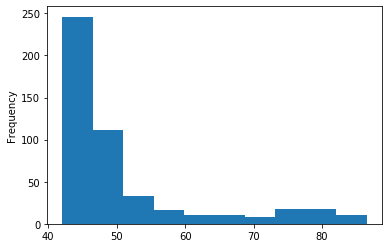

In [30]:
sample = train[train['building_id']==403]
sample['meter_reading'].plot.hist()

In [31]:
sample.shape

(479, 15)

In [32]:
%%time
X = sample.iloc[:,2:]
y = sample.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

bst = lgb.LGBMRegressor(n_estimators = 100)
bst.fit(X_train.values, y_train.values)

prediction_on_X_train = bst.predict(X_train)
prediction_on_X_train = pd.Series(prediction_on_X_train)
prediction_on_X_train[prediction_on_X_train<0] = 0
print('train: ', np.sqrt(mean_squared_log_error( y_train, prediction_on_X_train)))

prediction_on_X_test = bst.predict(X_test)
prediction_on_X_test = pd.Series(prediction_on_X_test)
prediction_on_X_test[prediction_on_X_test<0] = 0
print('test: ', np.sqrt(mean_squared_log_error( y_test, prediction_on_X_test )))

train:  0.019758227944799908
test:  0.03989536278172967
Wall time: 63.8 ms


#### First test seems promising, I am going to select 50 bulinds and train model on each of them

In [41]:
import random
samples = random.sample(set(building_list), 50)
print(samples)

[1062, 1032, 1422, 971, 503, 477, 277, 1211, 1417, 339, 848, 288, 1230, 541, 143, 113, 493, 388, 1023, 739, 69, 454, 662, 1357, 840, 924, 1060, 140, 1073, 953, 344, 144, 761, 91, 650, 1152, 1315, 1024, 795, 1203, 1219, 439, 110, 634, 733, 420, 1218, 548, 646, 515]


In [42]:
%%time
y_train_list = pd.Series()
y_test_list = pd.Series()

prediction_train = pd.Series()
prediction_test = pd.Series()

for sample in samples: 
    sample_df = train[train['building_id']==sample]
    X = sample_df.iloc[:,2:]
    y = sample_df.iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
    
    bst = lgb.LGBMRegressor(n_estimators = 100)
    bst.fit(X_train.values, y_train.values)
    
    prediction_on_X_train = bst.predict(X_train)
    prediction_on_X_train = pd.Series(prediction_on_X_train)
    prediction_on_X_train[prediction_on_X_train<0] = 0

    prediction_on_X_test = bst.predict(X_test)
    prediction_on_X_test = pd.Series(prediction_on_X_test)
    prediction_on_X_test[prediction_on_X_test<0] = 0
    
    y_train_list = pd.concat([y_train_list, y_train])
    y_test_list = pd.concat([y_test_list, y_test])

    prediction_train = pd.concat([prediction_train, prediction_on_X_train])
    prediction_test = pd.concat([prediction_test, prediction_on_X_test])

print('train: ', np.sqrt(mean_squared_log_error( y_train_list, prediction_train)))
print('test: ', np.sqrt(mean_squared_log_error( y_test_list, prediction_test)))

Wall time: 11.2 s


#### It looks like it works...so I want to try all of the buildings

In [44]:
%%time
y_train_list = pd.Series()
y_test_list = pd.Series()

prediction_train = pd.Series()
prediction_test = pd.Series()

for sample in building_list: 
    sample_df = train[train['building_id']==sample]
    X = sample_df.iloc[:,2:]
    y = sample_df.iloc[:,0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
    
    bst = lgb.LGBMRegressor(n_estimators = 100)
    bst.fit(X_train.values, y_train.values)
    
    prediction_on_X_train = bst.predict(X_train)
    prediction_on_X_train = pd.Series(prediction_on_X_train)
    prediction_on_X_train[prediction_on_X_train<0] = 0

    prediction_on_X_test = bst.predict(X_test)
    prediction_on_X_test = pd.Series(prediction_on_X_test)
    prediction_on_X_test[prediction_on_X_test<0] = 0
    
    y_train_list = pd.concat([y_train_list, y_train])
    y_test_list = pd.concat([y_test_list, y_test])

    prediction_train = pd.concat([prediction_train, prediction_on_X_train])
    prediction_test = pd.concat([prediction_test, prediction_on_X_test])

print('train: ', np.sqrt(mean_squared_log_error( y_train_list, prediction_train)))
print('test: ', np.sqrt(mean_squared_log_error( y_test_list, prediction_test)))

train:  0.7891547100761008
test:  0.8118887312070232
Wall time: 8min 2s
